In [1]:
!pip install pykan

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install git+https://github.com/fra31/auto-attack

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-cusisysf
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-cusisysf
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done


In [4]:
import torch
from torch import nn
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# from kan import *
from eKan import KAN
import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
from autoattack import AutoAttack
import torch.nn as nn

In [5]:
#### Load MNIST

print('==> Preparing data..')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

trainloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

print(train_dataset.data.shape)
print(test_dataset.data.shape)

==> Preparing data..
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
targets = test_dataset.targets.clone().detach()
num_classes = 10

# Create a list of indices for each class
class_indices = {i: torch.where(targets == i)[0].tolist() for i in range(num_classes)}

# Create a DataLoader for each class
class_loaders = {}
batch_size = 100  
for i in range(num_classes):
    # Subset the test dataset for class `i`
    class_subset = Subset(test_dataset, class_indices[i])
    # Create a DataLoader for this class
    class_loader = DataLoader(class_subset, batch_size=batch_size, shuffle=False, drop_last=True)
    # Store the DataLoader in a dictionary
    class_loaders[i] = class_loader

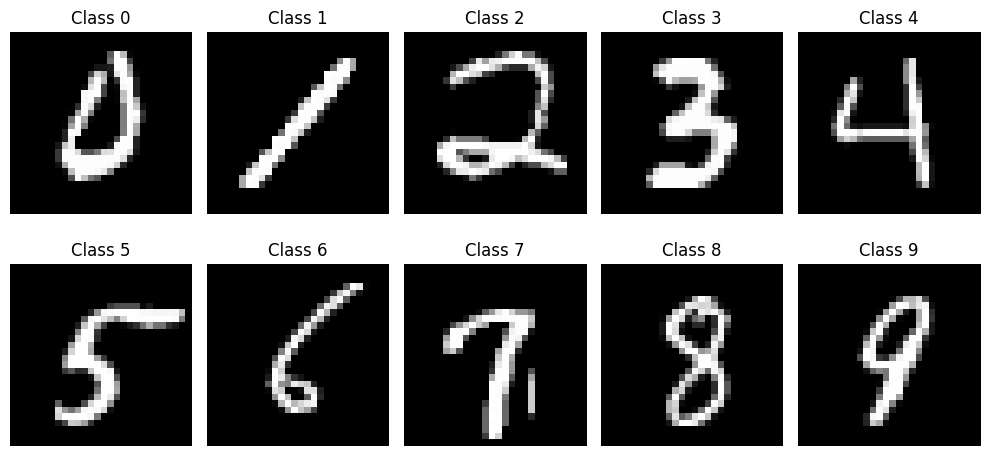

In [7]:
# Helper function to plot an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()

# Function to plot one image per class
def plot_images_per_class(trainloader):
    class_images = {}
    class_names = range(10)  # MNIST has 10 classes: 0-9

    for images, labels in trainloader:
        # Loop through the batch
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in class_images:
                class_images[label] = images[i]  # Store the image of the current class

            # Stop if we have one image per class
            if len(class_images) == len(class_names):
                break
        if len(class_images) == len(class_names):
            break

    # Plot the images
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows and 5 columns
    axes = axes.ravel()

    for i in range(10):
        img = class_images[i]
        axes[i].imshow(img.squeeze(), cmap="gray")
        axes[i].set_title(f'Class {i}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot images from the train_loader
plot_images_per_class(trainloader)


In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 110)
        self.fc2 = nn.Linear(110, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
class KANet(nn.Module):
    def __init__(self):
        super(KANet, self).__init__()
        self.flatten = nn.Flatten()
        self.kan1 = KAN([28*28,64])
        self.kan2 = KAN([64,10])
    
    def forward(self, x):
        out = self.flatten(x)
        out = self.kan1(out)
        out = self.kan2(out)

        return out
    
class CNN_KAN(nn.Module):
    def __init__(self):
        super(CNN_KAN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.kan1 = KAN([4608, 110])
        self.kan2 = KAN([110, 10])

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.kan1(x)
        x = self.kan2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
class MLPKAN1(nn.Module):
    def __init__(self):
        super(MLPKAN1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.kan3 = KAN([256,10])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.kan3(x)
        return x
    
class MLPKAN2(nn.Module):
    def __init__(self):
        super(MLPKAN2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.kan2 = KAN([512,256])
        self.kan3 = KAN([256,10])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.kan2(x)
        x = self.kan3(x)
        return x
    
class MLPKAN3(nn.Module):
    def __init__(self):
        super(MLPKAN3, self).__init__()
        self.flatten = nn.Flatten()
        self.kan1 = KAN([28*28, 512])
        self.kan2 = KAN([512,256])
        self.kan3 = KAN([256,10])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.kan1(x)
        x = self.kan2(x)
        x = self.kan3(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device,"\n")

device =  cuda 



In [11]:
model_mlp = MLP().to(device)
state_dict = torch.load('models/mnist_mlp_e40.pth')
model_mlp.load_state_dict(state_dict)


model_mlp_pgd = MLP().to(device)
state_dict = torch.load('models/mnist_mlp_e40_pgd.pth')
model_mlp_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_mlp.parameters() if p.requires_grad))

Number of model parameters -  535818


/tmp/ipykernel_1051140/727945128.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_mlp_e40.pth')
/tmp/ipykernel_1051140/727945128.py:

In [12]:
model_cnn = CNN().to(device)
state_dict = torch.load('models/mnist_cnn_e40.pth')
model_cnn.load_state_dict(state_dict)


model_cnn_pgd = CNN().to(device)
state_dict = torch.load('models/mnist_cnn_e40_pgd.pth')
model_cnn_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_cnn.parameters() if p.requires_grad))

Number of model parameters -  512900


/tmp/ipykernel_1051140/1394609088.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_cnn_e40.pth')
/tmp/ipykernel_1051140/1394609088.p

In [13]:
model_cnnkan = CNN_KAN().to(device)
state_dict = torch.load('models/mnist_cnnkan_e40.pth')
model_cnnkan.load_state_dict(state_dict)


model_cnnkan_pgd = CNN_KAN().to(device)
state_dict = torch.load('models/mnist_cnnkan_e40_pgd.pth')
model_cnnkan_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_cnnkan.parameters() if p.requires_grad))

/tmp/ipykernel_1051140/1553189633.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_cnnkan_e40.pth')
/tmp/ipykernel_1051140/155318963

Number of model parameters -  5084600


In [14]:
model_kan = KANet().to(device)
state_dict = torch.load('models/mnist_kan_e40.pth')
model_kan.load_state_dict(state_dict)


model_kan_pgd = KANet().to(device)
state_dict = torch.load('models/mnist_kan_e40_pgd.pth')
model_kan_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_kan.parameters() if p.requires_grad))

Number of model parameters -  508160


/tmp/ipykernel_1051140/3780883408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_kan_e40.pth')
/tmp/ipykernel_1051140/3780883408.p

In [15]:
model_mlpkan1 = MLPKAN1().to(device)
state_dict = torch.load('models/mnist_mlpkan1_e40.pth')
model_mlpkan1.load_state_dict(state_dict)


model_mlpkan1_pgd = MLPKAN1().to(device)
state_dict = torch.load('models/mnist_mlpkan1_e40_pgd.pth')
model_mlpkan1_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_mlpkan1.parameters() if p.requires_grad))

Number of model parameters -  558848


/tmp/ipykernel_1051140/3761300431.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_mlpkan1_e40.pth')
/tmp/ipykernel_1051140/37613004

In [16]:
model_mlpkan2 = MLPKAN2().to(device)
state_dict = torch.load('models/mnist_mlpkan2_e40.pth')
model_mlpkan2.load_state_dict(state_dict)


model_mlpkan2_pgd = MLPKAN2().to(device)
state_dict = torch.load('models/mnist_mlpkan2_e40_pgd.pth')
model_mlpkan2_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_mlpkan2.parameters() if p.requires_grad))

Number of model parameters -  1738240


/tmp/ipykernel_1051140/486945912.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_mlpkan2_e40.pth')
/tmp/ipykernel_1051140/486945912

In [17]:
model_mlpkan3 = MLPKAN3().to(device)
state_dict = torch.load('models/mnist_mlpkan3_e40.pth')
model_mlpkan3.load_state_dict(state_dict)


model_mlpkan3_pgd = MLPKAN3().to(device)
state_dict = torch.load('models/mnist_mlpkan3_e40_pgd.pth')
model_mlpkan3_pgd.load_state_dict(state_dict)


print("Number of model parameters - ", sum(p.numel() for p in model_mlpkan3.parameters() if p.requires_grad))

/tmp/ipykernel_1051140/2004204278.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_mlpkan3_e40.pth')


Number of model parameters -  5350400


/tmp/ipykernel_1051140/2004204278.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/mnist_mlpkan3_e40_pgd.pth')


In [18]:
def correctly_predicted(output,target):
  predicted = torch.argmax(output, dim=1)
  correct_ones = (predicted==target).type(torch.float)
  return correct_ones.sum().item()

In [19]:
def test(data_loader,model,Loss,GD):
  # print("reached here")
  model.eval()

  num_batches_test = len(data_loader)
  num_samples_test = len(data_loader.dataset)

  total_loss_test = 0
  total_accurate_test = 0

  #latent_representations_test = []

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(data_loader):


      ## copy to device
      data = data.to(device)
      target = target.to(device)



      ### forward pass
      output = model(data)

      #latent_representations_test.append(latent.cpu().detach().numpy())

      ### Calculate loss ###
      batch_loss = Loss(output,target)
      total_loss_test += batch_loss

      ### Count correctly predicted labels###
      correctly_predicted_count = correctly_predicted(output,target)
      total_accurate_test += correctly_predicted_count


  test_loss = total_loss_test/num_batches_test
  accuracy_test = total_accurate_test/num_samples_test
  print(f"Average test loss: {test_loss:4f}, test accuracy: {accuracy_test:.2%}")
  return test_loss, accuracy_test

In [20]:

def PGD(net,x,y,alpha,epsilon,iteration):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation budget 
        iter: number of iterations in the PGD algorithm

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''
    delta = torch.zeros_like(x, requires_grad=True)
    # print("iter val - ", iteration)
    for i in range(iteration):
        # print("iter - ", i)
        prev_delta = delta
        criterion=nn.CrossEntropyLoss()
        out = net(x+delta)
        loss = criterion(out, y)
        loss.backward()
        # print("delate grad - ", delta.grad.data)
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        # print(torch.sum(x.shape[0]*alpha*delta.grad.data))
        # print(torch.sum(delta-prev_delta))
        # print(delta.data-prev_delta.data)
        
        delta.grad.zero_()
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _,y_adv = torch.max(h_adv.data,1)
    return x_adv, h_adv, y_adv, pert

In [21]:
# activations = {}
# all_features = None


def test_pgd(data_loader, model, alpha, epsilon, iteration):
    num_batches = len(data_loader)
    num_samples = len(data_loader.dataset)

    total_loss = 0
    total_accurate = 0
    Loss = nn.CrossEntropyLoss()
    
    model.eval()

    for batch_idx, (data, target) in enumerate(data_loader):
        # if batch_idx % 100 == 0:
        #     print(f"\nBatch number: {batch_idx+1}")
        ## copy to gpu device
        data = data.to(device)
        target = target.to(device)
        x_adv,_,_,_ = PGD(model,data,target,alpha,epsilon,iteration)
        
        
        with torch.no_grad():
        ### forward pass
            output = model(x_adv)

            ### Calculate loss ###
            batch_loss = Loss(output,target)
            total_loss += batch_loss.item()

            ### Count correctly predicted labels###
            correctly_predicted_count = correctly_predicted(output,target)
            total_accurate += correctly_predicted_count
            
            # # For each sample in the batch
            # for i in range(data.size(0)):
            #     label = target[i].item()
            #     for layer_name, activation in activations.items():
            #         # If activation is a tensor with more than 2 dimensions (e.g., convolutional layers),
            #         # you may want to flatten or pool it before storing
            #         act = activation[i]
            #         act_flat = act.view(-1).cpu().numpy()  # Flatten the activation
            #         class_activations[layer_name][label].append(act_flat)
            
    test_loss = total_loss/num_batches
    accuracy = total_accurate/num_samples
    print(f"Average test loss: {test_loss:4f}, test accuracy: {accuracy:.2%}")
    print(test_loss, accuracy)
    return test_loss, accuracy



In [22]:
from collections import defaultdict
import builtins

label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [23]:


def test_iter_ranges(class_val, model, iters):
    for iter in iters:
        if(y==10):
            test_loss, accuracy = test_pgd(testloader, 
                                       model, 8/255, 0.2, iter)
            print("test accuracy for iters=",iter,": ",accuracy)
        else:
            test_loss, accuracy = test_pgd(class_loaders[class_val], 
                                       model, 8/255, 0.2, iter)
            print("class=",class_val, " iters=",iter,": ",accuracy)
        class_accs_iters[str(class_val)][str(iter)] = accuracy
        get_mean_class_features(class_val, parameter_type="iters", parameter_val=iter)
        
def test_alpha_ranges(class_val, model, alphas):
    for alpha in alphas:
        if(y==10):
            test_loss, accuracy = test_pgd(testloader, model, alpha/255, 0.2, 20)
            print("test accuracy for alpha - ",alpha,": ",accuracy)
        else:
            test_loss, accuracy = test_pgd(class_loaders[class_val], model, alpha/255, 0.2, 20)
            print("alphas=",alpha,": ",accuracy)
        class_accs_alphas[str(class_val)][str(alpha)] = accuracy
        get_mean_class_features(class_val, parameter_type="alphas", parameter_val=alpha)
        
def test_auto_apgdce(class_val, model):
    model.eval()
    adversary = AutoAttack(model, norm='Linf', eps=8/255, version='standard')
    adversary.attacks_to_run = ['apgd-ce']
    if(y==10):
        print("Testing testset - ")
        x_test, y_test = next(builtins.iter(testloader))
    else:
        print("Testing class - ", class_val)
        x_test, y_test = next(builtins.iter(class_loaders[class_val]))
    x_test = x_test.cuda()  # Move inputs to GPU if available
    y_test = y_test.cuda()
    x_adv = adversary.run_standard_evaluation(x_test, y_test, bs=100)
    with torch.no_grad():
        y_pred_adv = model(x_adv).argmax(dim=1)
        accuracy = (y_pred_adv == y_test).float().mean().item()
        class_accs_apgdce[str(class_val)] = accuracy
    get_mean_class_features(class_val, parameter_type="apgdce", parameter_val=0)
    # return dict_adv
    
def get_mean_class_features(class_val, parameter_type, parameter_val):
    # Visualize the intermediate activations
    for layer_name, activation in activations.items():
        # print(f'Layer: {layer_name}, Shape: {activation.shape}')
        # print("layer name - ", layer_name)
        layer_feat = []
        layer_avg = torch.mean(activation.reshape(activation.shape[0], -1), axis=0)
        layer_stddev = torch.std(activation.reshape(activation.shape[0], -1), axis=0)
        layer_feat.append(layer_avg)
        layer_feat.append(layer_stddev)
        if(parameter_type == "iters"):
            label_features_iters[str(class_val)][str(parameter_val)][layer_name] = layer_feat
        elif(parameter_type == "alphas"):
            label_features_alphas[str(class_val)][str(parameter_val)][layer_name] = layer_feat
        elif(parameter_type == "apgdce"):
            label_features_apgdce[str(class_val)][layer_name] = layer_feat

In [24]:
def print_structure(d, indent=0):
    for key, value in d.items():
        prefix = '    ' * indent  # Indentation for nested levels
        if isinstance(value, dict):
            print(f'{prefix}Key: {key}, Type: dict')
            print_structure(value, indent + 1)  # Recursively print the nested dictionary
        else:
            print(f'{prefix}Key: {key}, Type: {type(value).__name__}')

In [25]:
def print_model_layers(model):
    for i, layer in enumerate(model.layers):
        print(f"Layer {i}: {layer.name} - {layer.__class__.__name__} - {layer.output_shape}")

In [26]:
# Testing original resnet-kan model on PGD adversarial samples
iters = [0,10,20,30,40]
alphas = [0,4,8,12]

In [27]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_mlp.fc1.register_forward_hook(get_activation('fc1'))
model_mlp.fc2.register_forward_hook(get_activation('fc2'))
model_mlp.fc3.register_forward_hook(get_activation('fc3'))

In [28]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_mlp, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_mlp, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_mlp)

Testing for different iterations
Average test loss: 0.040831, test accuracy: 90.82%
0.040831089947864205 0.9081632653061225
class= 0  iters= 0 :  0.9081632653061225
Average test loss: 0.104630, test accuracy: 90.00%
0.10463013459553218 0.9
class= 0  iters= 10 :  0.9
Average test loss: 0.200122, test accuracy: 89.29%
0.20012219813522986 0.8928571428571429
class= 0  iters= 20 :  0.8928571428571429
Average test loss: 0.291422, test accuracy: 88.67%
0.2914222642203741 0.886734693877551
class= 0  iters= 30 :  0.886734693877551
Average test loss: 0.374249, test accuracy: 88.27%
0.37424911787901594 0.8826530612244898
class= 0  iters= 40 :  0.8826530612244898
Average test loss: 0.018355, test accuracy: 96.30%
0.018354825654321096 0.9629955947136564
class= 1  iters= 0 :  0.9629955947136564
Average test loss: 0.072614, test accuracy: 95.77%
0.07261435503394088 0.9577092511013215
class= 1  iters= 10 :  0.9577092511013215
Average test loss: 0.137632, test accuracy: 95.42%
0.137631808322939 0.95418

In [29]:
type(class_loaders[0])

torch.utils.data.dataloader.DataLoader

In [30]:
# print_structure(label_features_iters)
# # label_features_iters['0']['0']['layer1'].shape

In [31]:
# print_structure(label_features_alphas)
# label_features_iters['0']['0']['layer1'].shape

In [32]:
# print_structure(label_features_apgdce)
# label_features_iters['0']['0']['layer1'].shape

In [33]:
model_mlp_testdata = []
model_mlp_testdata.append(label_features_iters)
model_mlp_testdata.append(label_features_alphas)
model_mlp_testdata.append(label_features_apgdce)
model_mlp_testdata.append(class_accs_iters)
model_mlp_testdata.append(class_accs_alphas)
model_mlp_testdata.append(class_accs_apgdce)

In [34]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [35]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_mlp_pgd.fc1.register_forward_hook(get_activation('fc1'))
model_mlp_pgd.fc2.register_forward_hook(get_activation('fc2'))
model_mlp_pgd.fc3.register_forward_hook(get_activation('fc3'))

In [36]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_mlp_pgd, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    print("class val - ", y)
    test_alpha_ranges(y, model_mlp_pgd, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_mlp_pgd)

Testing for different iterations
Average test loss: 0.027777, test accuracy: 90.92%
0.027777422840396564 0.9091836734693878
class= 0  iters= 0 :  0.9091836734693878
Average test loss: 0.046373, test accuracy: 90.82%
0.04637301210702086 0.9081632653061225
class= 0  iters= 10 :  0.9081632653061225
Average test loss: 0.068994, test accuracy: 90.71%
0.06899364795471127 0.9071428571428571
class= 0  iters= 20 :  0.9071428571428571
Average test loss: 0.089704, test accuracy: 90.71%
0.0897037661052309 0.9071428571428571
class= 0  iters= 30 :  0.9071428571428571
Average test loss: 0.109940, test accuracy: 90.20%
0.10993975817432834 0.9020408163265307
class= 0  iters= 40 :  0.9020408163265307
Average test loss: 0.018352, test accuracy: 96.39%
0.01835219693285498 0.9638766519823788
class= 1  iters= 0 :  0.9638766519823788
Average test loss: 0.036018, test accuracy: 95.86%
0.03601783954284408 0.958590308370044
class= 1  iters= 10 :  0.958590308370044
Average test loss: 0.063131, test accuracy: 95.

In [37]:
model_mlp_pgd_testdata = []
model_mlp_pgd_testdata.append(label_features_iters)
model_mlp_pgd_testdata.append(label_features_alphas)
model_mlp_pgd_testdata.append(label_features_apgdce)
model_mlp_pgd_testdata.append(class_accs_iters)
model_mlp_pgd_testdata.append(class_accs_alphas)
model_mlp_pgd_testdata.append(class_accs_apgdce)

In [38]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [39]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_cnn.fc1.register_forward_hook(get_activation('fc1'))
model_cnn.fc2.register_forward_hook(get_activation('fc2'))
model_cnn.conv1.register_forward_hook(get_activation('conv1'))
model_cnn.conv2.register_forward_hook(get_activation('conv2'))


In [40]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_cnn, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_cnn, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_cnn)

Testing for different iterations
Average test loss: 0.009424, test accuracy: 91.43%
0.009423918170796242 0.9142857142857143
class= 0  iters= 0 :  0.9142857142857143
Average test loss: 0.024885, test accuracy: 91.33%
0.02488527501716615 0.9132653061224489
class= 0  iters= 10 :  0.9132653061224489
Average test loss: 0.039391, test accuracy: 91.22%
0.039391002034082905 0.9122448979591836
class= 0  iters= 20 :  0.9122448979591836
Average test loss: 0.055078, test accuracy: 91.12%
0.05507805076275771 0.9112244897959184
class= 0  iters= 30 :  0.9112244897959184
Average test loss: 0.071308, test accuracy: 91.02%
0.0713078100395958 0.9102040816326531
class= 0  iters= 40 :  0.9102040816326531
Average test loss: 0.007492, test accuracy: 96.56%
0.00749171441632577 0.9656387665198238
class= 1  iters= 0 :  0.9656387665198238
Average test loss: 0.025840, test accuracy: 96.30%
0.02584007272327488 0.9629955947136564
class= 1  iters= 10 :  0.9629955947136564
Average test loss: 0.050669, test accuracy: 

In [41]:
model_cnn_testdata = []
model_cnn_testdata.append(label_features_iters)
model_cnn_testdata.append(label_features_alphas)
model_cnn_testdata.append(label_features_apgdce)
model_cnn_testdata.append(class_accs_iters)
model_cnn_testdata.append(class_accs_alphas)
model_cnn_testdata.append(class_accs_apgdce)

In [42]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [43]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_cnn_pgd.fc1.register_forward_hook(get_activation('fc1'))
model_cnn_pgd.fc2.register_forward_hook(get_activation('fc2'))
model_cnn_pgd.conv1.register_forward_hook(get_activation('conv1'))
model_cnn_pgd.conv2.register_forward_hook(get_activation('conv2'))

In [44]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_cnn_pgd, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_cnn_pgd, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_cnn_pgd)

Testing for different iterations
Average test loss: 0.005920, test accuracy: 91.63%
0.005919674334614279 0.9163265306122449
class= 0  iters= 0 :  0.9163265306122449
Average test loss: 0.009045, test accuracy: 91.63%
0.009045389928764457 0.9163265306122449
class= 0  iters= 10 :  0.9163265306122449
Average test loss: 0.014380, test accuracy: 91.43%
0.014380323703436362 0.9142857142857143
class= 0  iters= 20 :  0.9142857142857143
Average test loss: 0.020738, test accuracy: 91.43%
0.020738362275652535 0.9142857142857143
class= 0  iters= 30 :  0.9142857142857143
Average test loss: 0.025128, test accuracy: 91.43%
0.025128380681659717 0.9142857142857143
class= 0  iters= 40 :  0.9142857142857143
Average test loss: 0.005541, test accuracy: 96.74%
0.00554087137888101 0.9674008810572687
class= 1  iters= 0 :  0.9674008810572687
Average test loss: 0.010989, test accuracy: 96.48%
0.01098901576849378 0.9647577092511013
class= 1  iters= 10 :  0.9647577092511013
Average test loss: 0.022164, test accura

In [45]:
model_cnn_pgd_testdata = []
model_cnn_pgd_testdata.append(label_features_iters)
model_cnn_pgd_testdata.append(label_features_alphas)
model_cnn_pgd_testdata.append(label_features_apgdce)
model_cnn_pgd_testdata.append(class_accs_iters)
model_cnn_pgd_testdata.append(class_accs_alphas)
model_cnn_pgd_testdata.append(class_accs_apgdce)

In [46]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [47]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_kan.kan1.register_forward_hook(get_activation('kan1'))
model_kan.kan2.register_forward_hook(get_activation('kan2'))

In [48]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_kan, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_kan, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_kan)

Testing for different iterations
Average test loss: 0.049658, test accuracy: 90.41%
0.04965834734159418 0.9040816326530612
class= 0  iters= 0 :  0.9040816326530612
Average test loss: 0.082857, test accuracy: 89.69%
0.08285677764150831 0.8969387755102041
class= 0  iters= 10 :  0.8969387755102041
Average test loss: 0.118528, test accuracy: 89.18%
0.1185279168550753 0.8918367346938776
class= 0  iters= 20 :  0.8918367346938776
Average test loss: 0.145960, test accuracy: 88.67%
0.14596045162761584 0.886734693877551
class= 0  iters= 30 :  0.886734693877551
Average test loss: 0.171099, test accuracy: 88.06%
0.17109899482845017 0.8806122448979592
class= 0  iters= 40 :  0.8806122448979592
Average test loss: 0.039555, test accuracy: 95.86%
0.03955480651083318 0.958590308370044
class= 1  iters= 0 :  0.958590308370044
Average test loss: 0.071592, test accuracy: 95.59%
0.0715921533040025 0.9559471365638766
class= 1  iters= 10 :  0.9559471365638766
Average test loss: 0.096423, test accuracy: 95.07%


In [49]:
model_kan_testdata = []
model_kan_testdata.append(label_features_iters)
model_kan_testdata.append(label_features_alphas)
model_kan_testdata.append(label_features_apgdce)
model_kan_testdata.append(class_accs_iters)
model_kan_testdata.append(class_accs_alphas)
model_kan_testdata.append(class_accs_apgdce)

In [50]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [51]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_kan_pgd.kan1.register_forward_hook(get_activation('kan1'))
model_kan_pgd.kan2.register_forward_hook(get_activation('kan2'))

In [52]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_kan_pgd, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_kan_pgd, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_kan_pgd)

Testing for different iterations
Average test loss: 0.039522, test accuracy: 91.02%
0.03952234163362947 0.9102040816326531
class= 0  iters= 0 :  0.9102040816326531
Average test loss: 0.051494, test accuracy: 90.71%
0.05149402663422128 0.9071428571428571
class= 0  iters= 10 :  0.9071428571428571
Average test loss: 0.064903, test accuracy: 90.20%
0.06490341359232035 0.9020408163265307
class= 0  iters= 20 :  0.9020408163265307
Average test loss: 0.077839, test accuracy: 89.69%
0.07783943259467681 0.8969387755102041
class= 0  iters= 30 :  0.8969387755102041
Average test loss: 0.089049, test accuracy: 89.49%
0.08904947079200712 0.8948979591836734
class= 0  iters= 40 :  0.8948979591836734
Average test loss: 0.042618, test accuracy: 96.12%
0.04261752988465808 0.9612334801762115
class= 1  iters= 0 :  0.9612334801762115
Average test loss: 0.055496, test accuracy: 95.77%
0.05549585599113594 0.9577092511013215
class= 1  iters= 10 :  0.9577092511013215
Average test loss: 0.069936, test accuracy: 9

In [53]:
model_kan_pgd_testdata = []
model_kan_pgd_testdata.append(label_features_iters)
model_kan_pgd_testdata.append(label_features_alphas)
model_kan_pgd_testdata.append(label_features_apgdce)
model_kan_pgd_testdata.append(class_accs_iters)
model_kan_pgd_testdata.append(class_accs_alphas)
model_kan_pgd_testdata.append(class_accs_apgdce)

In [54]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [55]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_cnnkan.kan1.register_forward_hook(get_activation('kan1'))
model_cnnkan.kan2.register_forward_hook(get_activation('kan2'))
model_cnnkan.conv1.register_forward_hook(get_activation('conv1'))
model_cnnkan.conv2.register_forward_hook(get_activation('conv2'))

In [56]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_cnnkan, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_cnnkan, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_cnnkan)

Testing for different iterations
Average test loss: 0.016990, test accuracy: 91.22%
0.01698975355571343 0.9122448979591836
class= 0  iters= 0 :  0.9122448979591836
Average test loss: 0.043253, test accuracy: 91.12%
0.04325300632182108 0.9112244897959184
class= 0  iters= 10 :  0.9112244897959184
Average test loss: 0.067067, test accuracy: 91.02%
0.06706702177648872 0.9102040816326531
class= 0  iters= 20 :  0.9102040816326531
Average test loss: 0.086917, test accuracy: 90.92%
0.0869169212419365 0.9091836734693878
class= 0  iters= 30 :  0.9091836734693878
Average test loss: 0.104263, test accuracy: 90.71%
0.10426335985943701 0.9071428571428571
class= 0  iters= 40 :  0.9071428571428571
Average test loss: 0.010690, test accuracy: 96.48%
0.010689511283999309 0.9647577092511013
class= 1  iters= 0 :  0.9647577092511013
Average test loss: 0.034797, test accuracy: 96.04%
0.03479663011173464 0.960352422907489
class= 1  iters= 10 :  0.960352422907489
Average test loss: 0.069348, test accuracy: 95.

In [57]:
model_cnnkan_testdata = []
model_cnnkan_testdata.append(label_features_iters)
model_cnnkan_testdata.append(label_features_alphas)
model_cnnkan_testdata.append(label_features_apgdce)
model_cnnkan_testdata.append(class_accs_iters)
model_cnnkan_testdata.append(class_accs_alphas)
model_cnnkan_testdata.append(class_accs_apgdce)

In [58]:
label_features_iters = defaultdict(lambda: defaultdict(dict))
label_features_alphas = defaultdict(lambda: defaultdict(dict))
label_features_apgdce = defaultdict(lambda: defaultdict(dict))
class_accs_iters = defaultdict(lambda: defaultdict(dict))
class_accs_alphas = defaultdict(lambda: defaultdict(dict))
class_accs_apgdce = defaultdict(lambda: defaultdict(dict))

In [59]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model_cnnkan_pgd.kan1.register_forward_hook(get_activation('kan1'))
model_cnnkan_pgd.kan2.register_forward_hook(get_activation('kan2'))
model_cnnkan_pgd.conv1.register_forward_hook(get_activation('conv1'))
model_cnnkan_pgd.conv2.register_forward_hook(get_activation('conv2'))

In [60]:
print("Testing for different iterations")
for y in range(num_classes+1):
    test_iter_ranges(y, model_cnnkan_pgd, iters)
print("Testing for different alphas")
for y in range(num_classes+1):
    test_alpha_ranges(y, model_cnnkan_pgd, alphas)
print("Testing APGD-CE for eps=8/255 and linf norm")
for y in range(num_classes+1):
    test_auto_apgdce(y, model_cnnkan_pgd)

Testing for different iterations
Average test loss: 0.011565, test accuracy: 91.43%
0.011564717902122842 0.9142857142857143
class= 0  iters= 0 :  0.9142857142857143
Average test loss: 0.019302, test accuracy: 91.12%
0.01930193062435137 0.9112244897959184
class= 0  iters= 10 :  0.9112244897959184
Average test loss: 0.030580, test accuracy: 91.02%
0.030579833694597863 0.9102040816326531
class= 0  iters= 20 :  0.9102040816326531
Average test loss: 0.041926, test accuracy: 90.92%
0.04192560569693645 0.9091836734693878
class= 0  iters= 30 :  0.9091836734693878
Average test loss: 0.050786, test accuracy: 90.92%
0.05078644373861607 0.9091836734693878
class= 0  iters= 40 :  0.9091836734693878
Average test loss: 0.010935, test accuracy: 96.56%
0.010935449792834168 0.9656387665198238
class= 1  iters= 0 :  0.9656387665198238
Average test loss: 0.021288, test accuracy: 96.21%
0.021288495193320243 0.9621145374449339
class= 1  iters= 10 :  0.9621145374449339
Average test loss: 0.038663, test accurac

In [61]:
model_cnnkan_pgd_testdata = []
model_cnnkan_pgd_testdata.append(label_features_iters)
model_cnnkan_pgd_testdata.append(label_features_alphas)
model_cnnkan_pgd_testdata.append(label_features_apgdce)
model_cnnkan_pgd_testdata.append(class_accs_iters)
model_cnnkan_pgd_testdata.append(class_accs_alphas)
model_cnnkan_pgd_testdata.append(class_accs_apgdce)

In [62]:
# # tested models

# model_mlp
# model_mlp_pgd
# model_cnn
# model_cnn_pgd
# model_kan
# model_kan_pgd
# model_cnnkan
# model_cnnkan_pgd

# # list structure

# 11 classes - 10 classes values + average overall value

# label_features_iters
# label_features_alphas
# label_features_apgdce
# class_accs_iters
# class_accs_alphas
# class_accs_apgdce

In [63]:
print_structure(model_mlp_testdata[3])

Key: 0, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float
Key: 1, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float
Key: 2, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float
Key: 3, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float
Key: 4, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float
Key: 5, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float
Key: 6, Type: dict
    Key: 0, Type: float
    Key: 10, Type: float
    Key: 20, Type: float
    Key: 30, Type: float
    Key: 40, Type: float

In [65]:
# print_structure(model_mlpkan3_pgd_testdata[0])

In [79]:
def plot_class_accs(model_accs, model_pgd_accs):
    # Number of bars
    n = len(model_accs)

    # Create an array for the positions of the bars
    x = np.arange(n)

    # Width of the bars
    width = 0.35
    
    def add_values_on_bars(bars):
        for bar in bars:
            height = bar.get_height()
            # Format height to 2 decimal places
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)
        
    # Plot the bars
    bars1 = plt.bar(x - width/2, model_accs, width, color='b')
    bars2 = plt.bar(x + width/2, model_pgd_accs, width, color='r')
    
    add_values_on_bars(bars1)
    add_values_on_bars(bars2)
    
    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(x)  # Set x-axis ticks to match the bar positions
    plt.legend()   # Show legend to differentiate the bars

    # Display the plot
    plt.show()

In [80]:
def plot_model_class_advaccs(model1_pgd_accs, model2_pgd_accs, model3_pgd_accs, model4_pgd_accs):
    n = len(model1_pgd_accs)

    # Create an array for the positions of the bars
    x = np.arange(n)

    # Width of the bars
    width = 0.20  # Slightly smaller width to accommodate 4 bars
    categories = ['MLP', 'CNN', 'KAN', 'CNNKAN']
    
    def add_values_on_bars(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation=90, fontsize=8)
            
    # Plot the bars
    bars1 = plt.bar(x - 1.5*width, model1_pgd_accs, width, color='b')    # First set of bars
    bars2 = plt.bar(x - 0.5*width, model2_pgd_accs, width,  color='r')             # Second set of bars
    bars3 = plt.bar(x + 0.5*width, model3_pgd_accs, width,  color='g')     # Third set of bars
    bars4 = plt.bar(x + 1.5*width, model4_pgd_accs, width,  color='orange')
    
    add_values_on_bars(bars1)
    add_values_on_bars(bars2)
    add_values_on_bars(bars3)
    add_values_on_bars(bars4)
    
    # Add labels and title
    plt.xlabel('PGD Models')
    plt.ylabel('Accuracies')
    plt.xticks(x)  # Set x-axis ticks to match the bar positions
    plt.legend()   # Show legend to differentiate the bars

    # Display the plot
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN1 accuracies for iterations=20


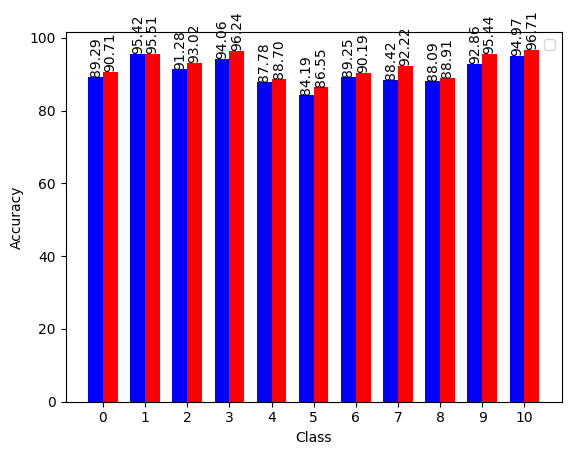

In [69]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 20
for i in model_mlp_testdata[3].keys():
    model_accs.append(model_mlp_testdata[3][i]['20']*100)
for i in model_mlp_pgd_testdata[3].keys():
    model_pgd_accs.append(model_mlp_pgd_testdata[3][i]['20']*100)

print("Plotting MLPKAN1 accuracies for iterations=20")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN2 accuracies for iterations=20


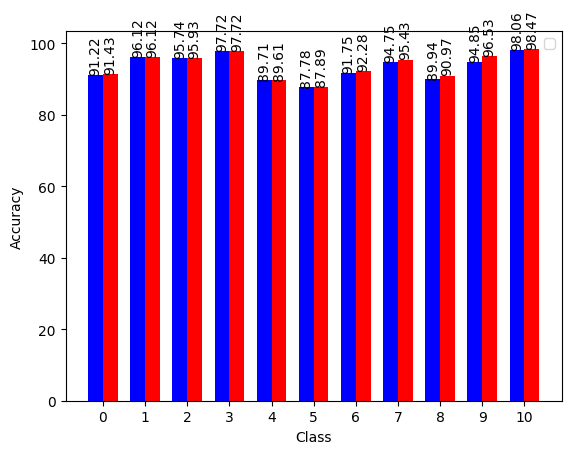

In [70]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 20
for i in model_cnn_testdata[3].keys():
    model_accs.append(model_cnn_testdata[3][i]['20']*100)
for i in model_cnn_pgd_testdata[3].keys():
    model_pgd_accs.append(model_cnn_pgd_testdata[3][i]['20']*100)

print("Plotting MLPKAN2 accuracies for iterations=20")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN3 accuracies for iterations=20


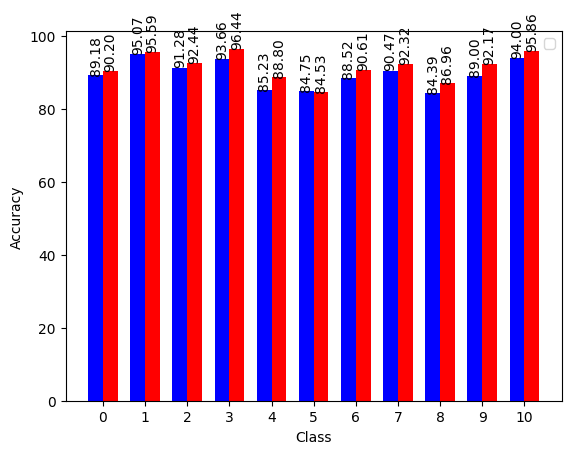

In [71]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 20
for i in model_kan_testdata[3].keys():
    model_accs.append(model_kan_testdata[3][i]['20']*100)
for i in model_kan_pgd_testdata[3].keys():
    model_pgd_accs.append(model_kan_pgd_testdata[3][i]['20']*100)

print("Plotting MLPKAN3 accuracies for iterations=20")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN3 accuracies for iterations=20


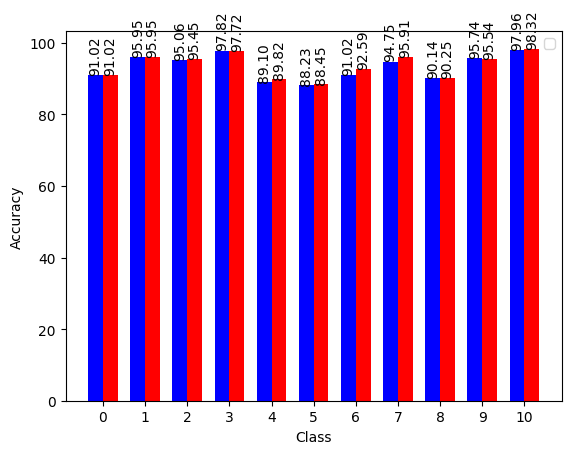

In [72]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 20
for i in model_cnnkan_testdata[3].keys():
    model_accs.append(model_cnnkan_testdata[3][i]['20']*100)
for i in model_cnnkan_pgd_testdata[3].keys():
    model_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['20']*100)

print("Plotting MLPKAN3 accuracies for iterations=20")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN1 accuracies for iterations=40


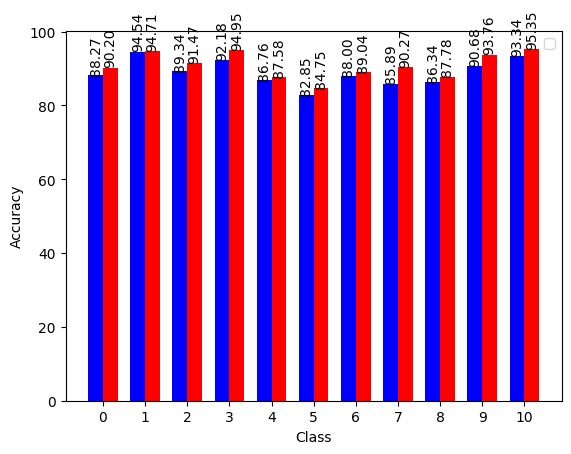

In [73]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 40
for i in model_mlp_testdata[3].keys():
    model_accs.append(model_mlp_testdata[3][i]['40']*100)
for i in model_mlp_pgd_testdata[3].keys():
    model_pgd_accs.append(model_mlp_pgd_testdata[3][i]['40']*100)

print("Plotting MLPKAN1 accuracies for iterations=40")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN2 accuracies for iterations=40


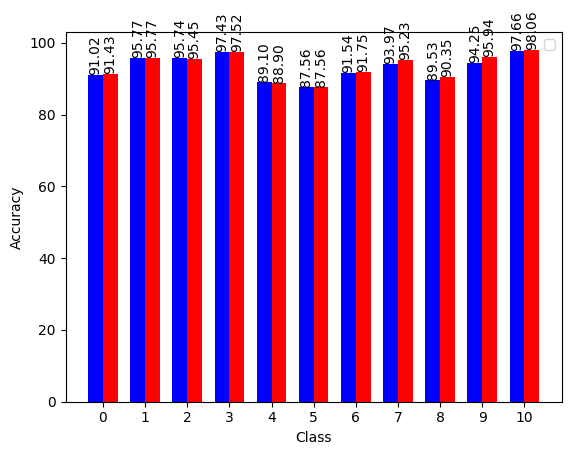

In [74]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 40
for i in model_cnn_testdata[3].keys():
    model_accs.append(model_cnn_testdata[3][i]['40']*100)
for i in model_cnn_pgd_testdata[3].keys():
    model_pgd_accs.append(model_cnn_pgd_testdata[3][i]['40']*100)

print("Plotting MLPKAN2 accuracies for iterations=40")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN3 accuracies for iterations=40


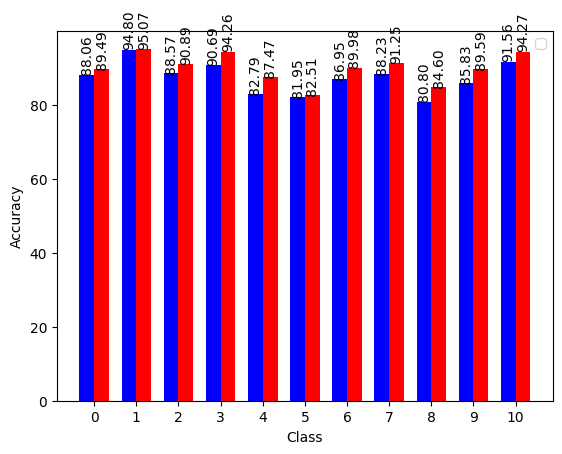

In [75]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 40
for i in model_kan_testdata[3].keys():
    model_accs.append(model_kan_testdata[3][i]['40']*100)
for i in model_kan_pgd_testdata[3].keys():
    model_pgd_accs.append(model_kan_pgd_testdata[3][i]['40']*100)

print("Plotting MLPKAN3 accuracies for iterations=40")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting MLPKAN3 accuracies for iterations=40


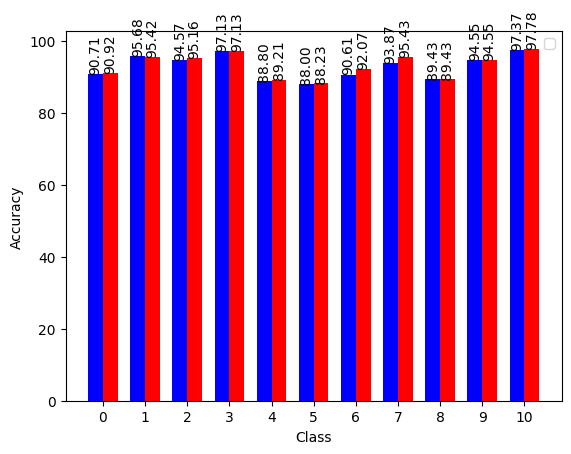

In [76]:
model_accs = []
model_pgd_accs = []

# plots for iterations = 40
for i in model_cnnkan_testdata[3].keys():
    model_accs.append(model_cnnkan_testdata[3][i]['40']*100)
for i in model_cnnkan_pgd_testdata[3].keys():
    model_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['40']*100)

print("Plotting MLPKAN3 accuracies for iterations=40")
plot_class_accs(model_accs, model_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue - MLP, red - CNN, green - KAN, orange - MLPKAN


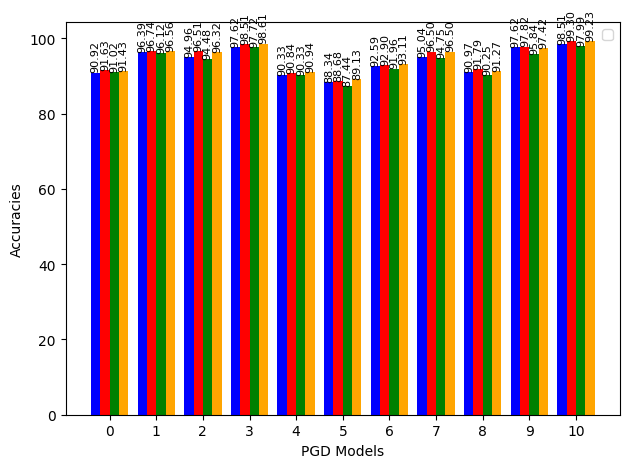

In [82]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

# plots for iterations = 0
for i in model_mlp_testdata[3].keys():
    model1_pgd_accs.append(model_mlp_pgd_testdata[3][i]['0']*100)
    model2_pgd_accs.append(model_cnn_pgd_testdata[3][i]['0']*100)
    model3_pgd_accs.append(model_kan_pgd_testdata[3][i]['0']*100)
    model4_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['0']*100)
    
print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_class_advaccs(model1_pgd_accs, 
                         model2_pgd_accs, 
                         model3_pgd_accs,
                         model4_pgd_accs)

blue - MLP, red - CNN, green - KAN, orange - MLPKAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


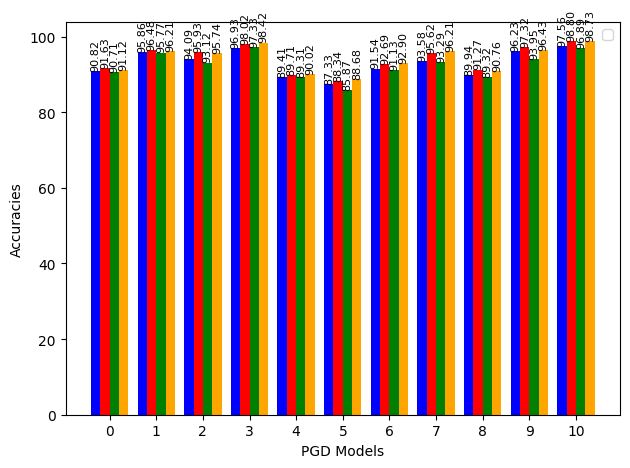

In [83]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

# plots for iterations = 0
for i in model_mlp_testdata[3].keys():
    model1_pgd_accs.append(model_mlp_pgd_testdata[3][i]['10']*100)
    model2_pgd_accs.append(model_cnn_pgd_testdata[3][i]['10']*100)
    model3_pgd_accs.append(model_kan_pgd_testdata[3][i]['10']*100)
    model4_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['10']*100)
    
print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_class_advaccs(model1_pgd_accs, 
                         model2_pgd_accs, 
                         model3_pgd_accs,
                         model4_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue - MLP, red - CNN, green - KAN, orange - MLPKAN


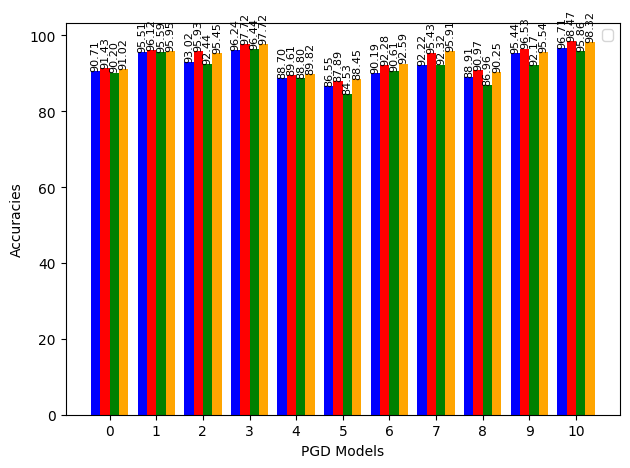

In [84]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

# plots for iterations = 0
for i in model_mlp_testdata[3].keys():
    model1_pgd_accs.append(model_mlp_pgd_testdata[3][i]['20']*100)
    model2_pgd_accs.append(model_cnn_pgd_testdata[3][i]['20']*100)
    model3_pgd_accs.append(model_kan_pgd_testdata[3][i]['20']*100)
    model4_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['20']*100)
    
print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_class_advaccs(model1_pgd_accs, 
                         model2_pgd_accs, 
                         model3_pgd_accs,
                         model4_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue - MLP, red - CNN, green - KAN, orange - MLPKAN


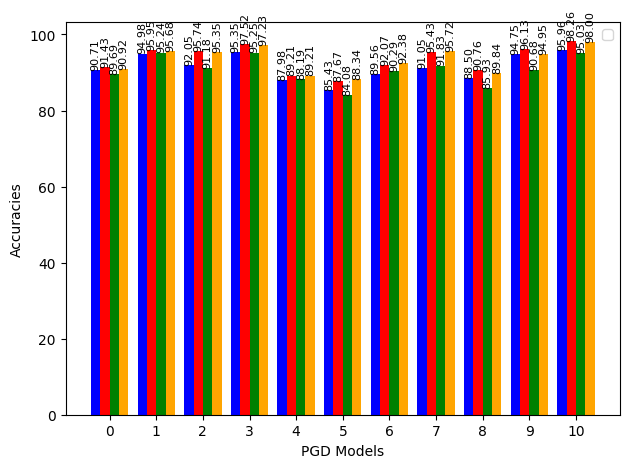

In [85]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

# plots for iterations = 0
for i in model_mlp_testdata[3].keys():
    model1_pgd_accs.append(model_mlp_pgd_testdata[3][i]['30']*100)
    model2_pgd_accs.append(model_cnn_pgd_testdata[3][i]['30']*100)
    model3_pgd_accs.append(model_kan_pgd_testdata[3][i]['30']*100)
    model4_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['30']*100)
    
print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_class_advaccs(model1_pgd_accs, 
                         model2_pgd_accs, 
                         model3_pgd_accs,
                         model4_pgd_accs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue - MLP, red - CNN, green - KAN, orange - MLPKAN


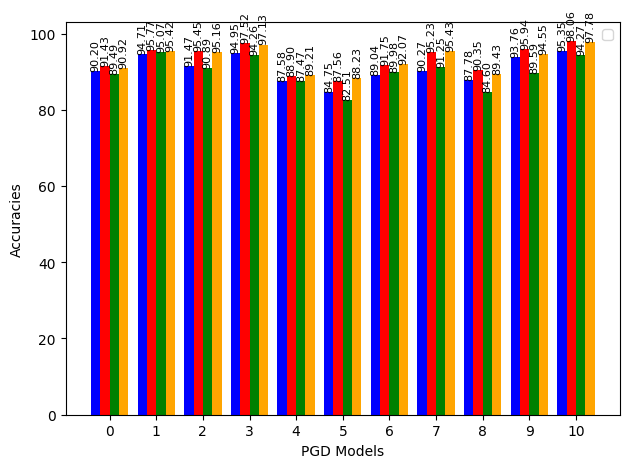

In [86]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

# plots for iterations = 0
for i in model_mlp_testdata[3].keys():
    model1_pgd_accs.append(model_mlp_pgd_testdata[3][i]['40']*100)
    model2_pgd_accs.append(model_cnn_pgd_testdata[3][i]['40']*100)
    model3_pgd_accs.append(model_kan_pgd_testdata[3][i]['40']*100)
    model4_pgd_accs.append(model_cnnkan_pgd_testdata[3][i]['40']*100)
    
print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_class_advaccs(model1_pgd_accs, 
                         model2_pgd_accs, 
                         model3_pgd_accs,
                         model4_pgd_accs)

In [104]:
def plot_accs_apgdce(data, data_pgd):
    accs = []
    accs_pgd = []
    for i in range(11):
        accs.append(data[str(i)]*100)
        accs_pgd.append(data_pgd[str(i)]*100)
        
    x = np.arange(len(accs))  # Create the x-axis positions for the bars
    width = 0.35  # Width of the bars
    
    def add_values_on_bars(bars):
        for bar in bars:
            height = bar.get_height()
            # Format height to 2 decimal places
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation=90)
            
    # Create the bar chart
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, accs, width)
    bars2 = ax.bar(x + width/2, accs_pgd, width)
    
    add_values_on_bars(bars1)
    add_values_on_bars(bars2)

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Classes')
    ax.set_ylabel('Accuracies')
    ax.set_xticks(x)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
    

In [105]:
def plot_model_accs_apgdce(model1_apgd, model2_apgd, model3_apgd, model4_apgd):
    model1_apgd_accs = []
    model2_apgd_accs = []
    model3_apgd_accs = []
    model4_apgd_accs = []
    
    for i in range(11):
        model1_apgd_accs.append(model1_apgd[str(i)]*100)
        model2_apgd_accs.append(model2_apgd[str(i)]*100)
        model3_apgd_accs.append(model3_apgd[str(i)]*100)
        model4_apgd_accs.append(model4_apgd[str(i)]*100)
        
    n = len(model1_apgd_accs)
    print("length - ", n)
    # Create an array for the positions of the bars
    x = np.arange(n)

    # Width of the bars
    width = 0.20  # Slightly smaller width to accommodate 4 bars
    categories = ['MLP', 'CNN', 'KAN', 'CNNKAN']
    
    def add_values_on_bars(bars):
        for bar in bars:
            height = bar.get_height()
            # Format height to 2 decimal places
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation=90, fontsize=8)
    
    
    
    # Plot the bars
    bars1 = plt.bar(x - 1.5*width, model1_apgd_accs, width, color='b')    # First set of bars
    bars2 = plt.bar(x - 0.5*width, model2_apgd_accs, width,  color='r')             # Second set of bars
    bars3 = plt.bar(x + 0.5*width, model3_apgd_accs, width,  color='g')     # Third set of bars
    bars4 = plt.bar(x + 1.5*width, model4_apgd_accs, width,  color='orange')
    
    add_values_on_bars(bars1)
    add_values_on_bars(bars2)
    add_values_on_bars(bars3)
    add_values_on_bars(bars4)
    
    # Add labels and title
    plt.xlabel('APGD Models')
    plt.ylabel('Accuracies')
    plt.xticks(x)  # Set x-axis ticks to match the bar positions
    plt.legend()   # Show legend to differentiate the bars

    # Display the plot
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


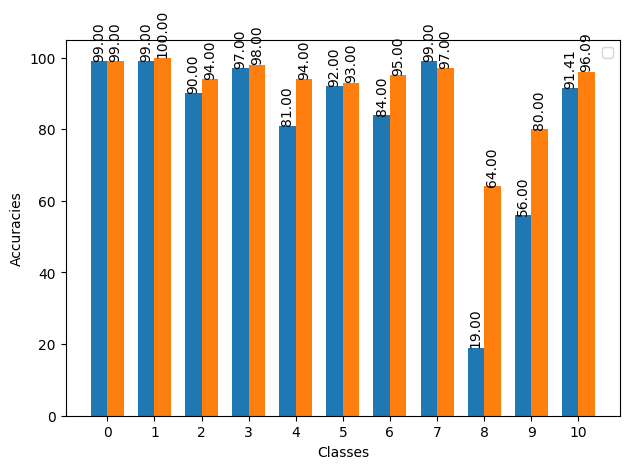

In [106]:
plot_accs_apgdce(model_mlp_testdata[5],
                 model_mlp_pgd_testdata[5])
                 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


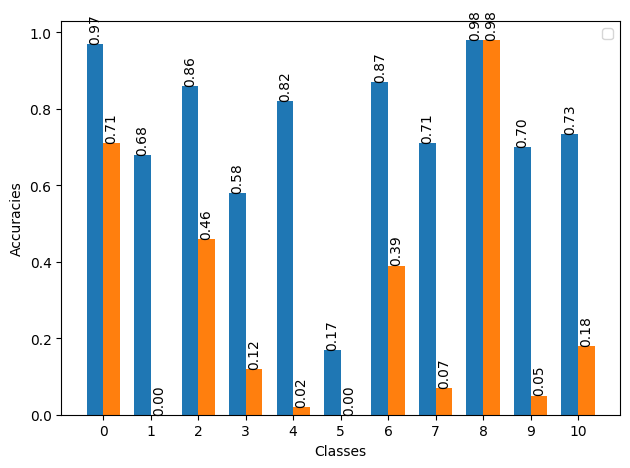

In [98]:
plot_accs_apgdce(model_cnn_testdata[5],
                 model_cnn_pgd_testdata[5])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


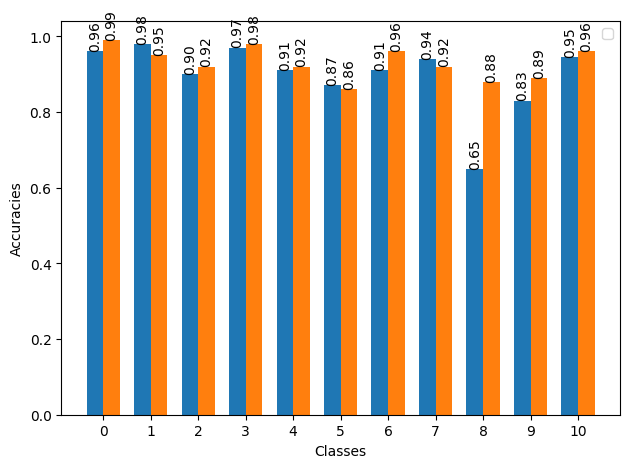

In [99]:
plot_accs_apgdce(model_kan_testdata[5],
                 model_kan_pgd_testdata[5])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


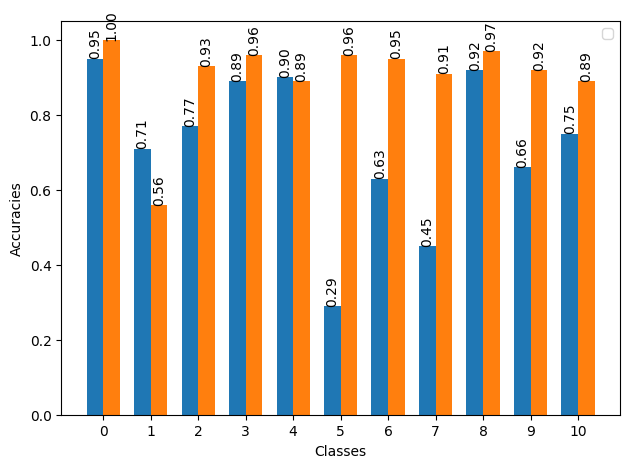

In [100]:
plot_accs_apgdce(model_cnnkan_testdata[5],
                 model_cnnkan_pgd_testdata[5])

In [ ]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_accs_apgdce(model_mlp_testdata[5], 
                         model_cnn_testdata[5], 
                         model_kan_testdata[5],
                         model_cnnkan_testdata[5])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue - MLP, red - CNN, green - KAN, orange - MLPKAN
length -  11


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue - MLP, red - CNN, green - KAN, orange - MLPKAN
length -  11


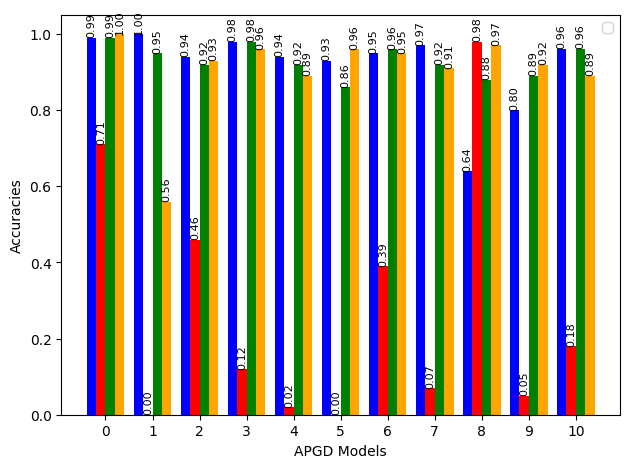

In [103]:
model1_pgd_accs = []
model2_pgd_accs = []
model3_pgd_accs = []
model4_pgd_accs = []

print("blue - MLP, red - CNN, green - KAN, orange - MLPKAN")

plot_model_accs_apgdce(model_mlp_pgd_testdata[5], 
                         model_cnn_pgd_testdata[5], 
                         model_kan_pgd_testdata[5],
                         model_cnnkan_pgd_testdata[5])

In [82]:
def plot_layer_activations(layers, layers_pgd):
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    width = 0.35
    i=0
    for key in layers.keys():
        print("i - ", i)
        feat_mean = layers[key][0].cpu()
        print(len(feat_mean))
        feat_std = layers[key][1].cpu()
        feat_mean_pgd = layers_pgd[key][0].cpu()
        feat_std_pgd = layers_pgd[key][1].cpu()
                      
        x = np.arange(len(feat_mean))  # X positions for the bars
                      
        axs[i].bar(x - width/2, feat_mean, width, yerr=feat_std, label='Normal', capsize=5)
        axs[i].bar(x + width/2, feat_mean_pgd, width, yerr=feat_std_pgd, label='PGD', capsize=5)
        axs[i].set_xlabel('Features')
        axs[i].set_ylabel('Mean Values')
        axs[i].set_title('Normal and PGD models')
        axs[i].set_xticks(x)
        axs[i].legend()
                      
        i+=1

    plt.tight_layout()
    plt.show()

MLPKAN1 features comparision
i -  0
512
i -  1
256
i -  2
10


IndexError: index 2 is out of bounds for axis 0 with size 2

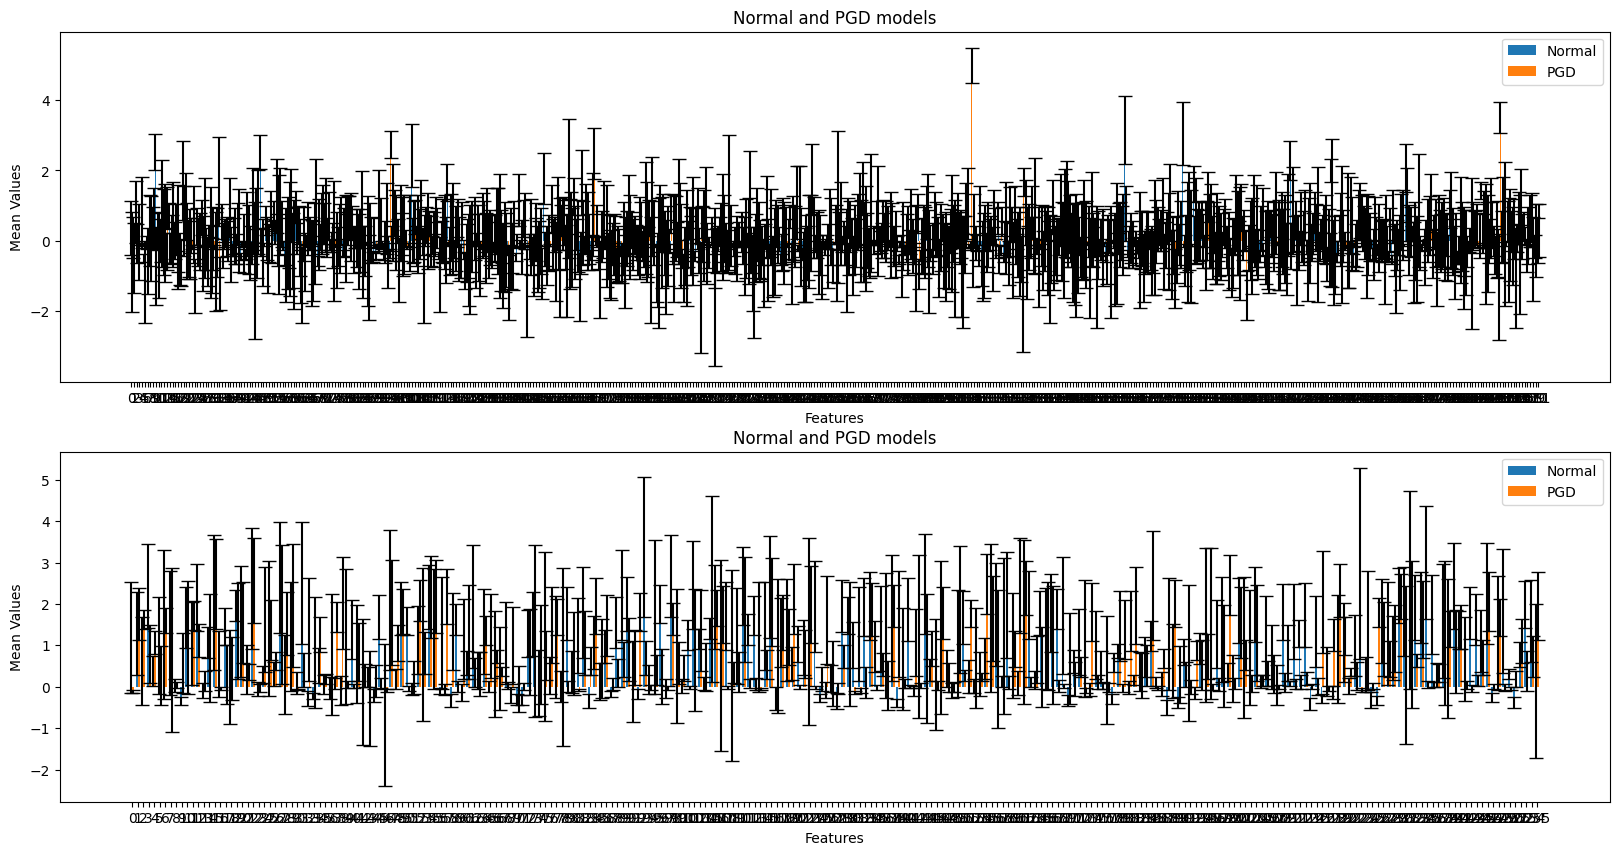

In [83]:
# MLPKAN1 features Normal vs PGD
print("MLPKAN1 features comparision")
plot_layer_activations(model_mlpkan1_testdata[0]['10']['20'],
                      model_mlpkan1_pgd_testdata[0]['10']['20'])

In [ ]:
# MLPKAN2 features Normal vs PGD
print("MLPKAN2 features comparision")
plot_layer_activations(model_mlpkan2_testdata[0]['10']['20'],
                      model_mlpkan2_pgd_testdata[0]['10']['20'])

In [ ]:
# MLPKAN3 features Normal vs PGD
print("MLPKAN3 features comparision")
plot_layer_activations(model_mlpkan3_testdata[0]['10']['20'],
                      model_mlpkan3_pgd_testdata[0]['10']['20'])

In [138]:
type(model_mlpkan1_pgd_testdata[0]['10']['20']['fc1'][0])

torch.Tensor